# Feedforward Neural Networks and Backpropagation

In [1]:
import numpy as np  # Fast math and arrays
import matplotlib.pyplot as plt  # Displays
%matplotlib inline  

## Feedforward neural networks

To alleviate the problems of perceptrons, we need to complicate our networks in two ways:

1. First, introducing non-linear activation functions
2. Second, adding a new layer (the _hidden_ layer) between input and output

The most common non-linear activation functions are the _sigmoid_ function and the hyperbolic tangent (_tanh_) function.

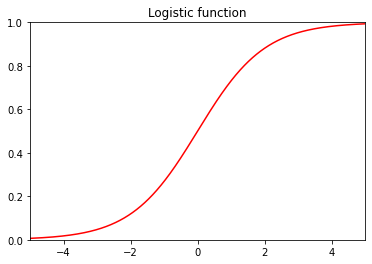

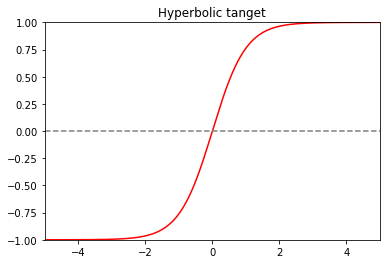

In [2]:
x = np.arange(-500, 500)/100.0

def calculate_response(val):
    """Calculates the response of the neuron to a digit"""
    set_inputs(val)
    return activation()


def logistic(x, gain = 1.0):
    """Sigmoid logistic function"""
    return 1 / (1 + np.exp(-x * gain))

def hypertan(x, gain = 1.0):
    """Hyperbolic tangent"""
    return np.tanh(x * gain)

y1 = [logistic(j) for j in x]
ymin, ymax = (0, 1)
plt.axis([-5, 5, ymin, ymax])
plt.plot(x, y1, 'red')
plt.title("Logistic function")
plt.show()

y2 = [hypertan(j) for j in x]
ymin, ymax = (-1, 1)
plt.axis([-5, 5, ymin, ymax])
plt.plot(x, y2, 'red')
plt.plot([-5, 5], [0, 0], "--", color="grey")
plt.title("Hyperbolic tanget")
plt.show()

## Backpropagation

Backpropagatio is a generalization of the gradient descent algorithm. 

To calculate the gradient, we apply the chain rule twice:

$$
\frac{\partial E}{\partial w_{i,j}} = \frac{\partial E}{\partial y_j}  \frac{\partial y_j}{\partial \textrm{in}_j}  \frac{\partial \textrm{in}_j}{\partial w_{i,j}}
$$

where $in_j$ is the net (summed) input to neuron $j$, and $y_j$ is its output: $y_j = f(\textrm{in}_j)$

Now, we can consider these three factors separately.  

The second factor is the derivative of the activation function

$$
\begin{aligned}
\frac{\partial y_j}{\partial \textrm{in}_j} &= \frac{\partial f(\textrm{in}_j)}{\partial \textrm{in}_j} \\
&= f'(\textrm{in}_j) 
\end{aligned}
$$

And the third factor the output of the pre-synaptic neuron:

$$
\begin{aligned}
\frac{\partial \textrm{in}_j}{\partial w_{i,j}} &= \frac{\partial \sum_k w_{k,j}y_k}{\partial w_{i,j}} \\
&= y_i
\end{aligned}
$$

Now, the first factor is the error with respect to the output. In the case of the output layer, this can be calculated directly. But how about the middle layer(s)?

The intuition is that $\frac{\partial E}{\partial y_j}$ can be calculated recursively. If we know the error of the layer below, we know how the error is affected by changes of $y_j$! in fact, that can be calculated as...

$$
\frac{\partial E}{\partial y_j} = \sum_k (\frac{\partial E}{\partial y_k} \frac{\partial y_k}{\partial \textrm{in}_k} w_{j,k})
$$

Note that the first two terms in the equation can be calculated as above. In fact, the formula is recursive: You can calculate $\frac{\partial E}{\partial y_j}$ for neuron $j$ using the results of the calculations of $\frac{\partial E}{\partial y_k}$ $\frac{\partial y_k}{\partial \textrm{in}_k}$, for neuron $k$, which is in located in the layer just beneath. So, if you proceed from the bottom layer up, you can iteratively calculate these values and recycle them through the layers. Because we can measure exactly the error of the bottom (output) layer, we can recurively calculate the error in the upper layer by multiplying it by the synpatic layer in between.

And that, of course, how backpropagation got its name: We are propagating back the error through the synaptic matrices!  

/home/andrea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


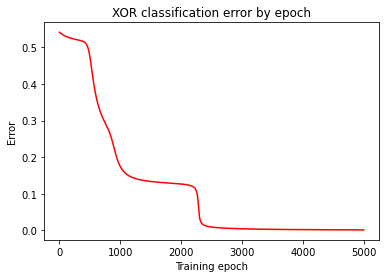

ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of ticklabels (4).

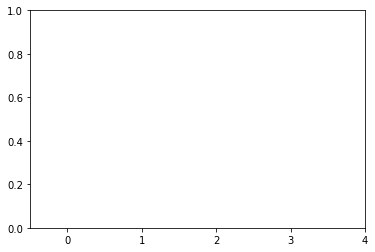

In [3]:
# A Feedforward neural network solving the XOR problem with backprop.

#plt.style.use('bmh')
n_input  = 2
n_hidden = 5
n_output = 1

x  = np.zeros((1, n_input))                              # Input values
w1 = (np.random.random((n_input, n_hidden)) / 5) - 0.1    # First layer of synapses
h  = np.zeros((1, n_hidden))                              # Hidden layer
w2 = (np.random.random((n_hidden, n_output)) / 5) - 0.1   # Second layer of synapses

eta = 1.0   # Learning rate. This is higher than usual.

# The patterns to learn

patterns = [[0, 0], [0, 1], [1, 0], [1, 1]]

# Redefining some crucial functions

def logistic(x, deriv = False):
    """Sigmoid logistic function (with derivative)"""
    if deriv:
        return x * (1 - x)
    else:
        return 1 / (1 + np.exp(-x))

    
def set_inputs(vals):
    """Sets a given XOR pattern into the input value"""
    global x
    x = np.array(vals).reshape((1,2))
    
    
def activation():
    """Spreads activation through a network"""
    global h
    
    # First pass, from input to hidden layer
    h_input = np.dot(x, w1)
    h = logistic(h_input)
    
    # Second pass, from input layer to output
    output_input = np.dot(h, w2)
    return logistic(output_input)


def target(val):
    """Desired response function, t(p)"""
    if  np.all(val == np.array([0, 1])) or np.all(val == np.array([1, 0])):
        return 1.0
    else:
        return 0.0

def error(i, response):
    """Calculates the error function"""
    return 0.5 * ((target(i) - response) ** 2)

    
def backprop(n = 1):
    """Performs the backpropagation algorithm over N epochs, returns error function"""
    E = []
    global w1
    global w2
    for i in np.arange(n):
        e = 0.0

        for p in patterns:
            o = calculate_response(p)
            e += error(p, o)
            
            # Error in output layer
            o_error = target(p) - o
            do = o_error * logistic(o, deriv = True)
            
            # error in hidden layer
            h_error = np.dot(do, w2.T) 
            dh = h_error * logistic(h, deriv = True)
            
            # If you had other layers, we could go on and on...
            
            dw2 = np.dot(h.T, do) 
            dw1 = np.dot(x.T, dh)
            
            w2 += eta * dw2
            w1 += eta * dw1
        
        E.append(np.asscalar(e))  # Error at epoch i 
    return E  # Returns the list of error by epoch
            

# Plot the error function by epoch
plt.plot(backprop(5000), "r-")
plt.xlabel("Training epoch")
plt.ylabel("Error")
plt.title("XOR classification error by epoch")
plt.show()

# Plot the responses to the XOR patterns
y_end = [calculate_response(p) for p in patterns]
fig, ax = plt.subplots()
ax.axis([-0.5, 3.5, 0, 1])
ax.set_xticks(np.arange(5))
ax.set_xticklabels(["(%s,%s)" % tuple(p) for p in patterns])
ax.set_ylabel("Activation")
ax.set_xlabel("Patterns")
ax.bar(np.arange(4), [float(y) for y in y_end], 0.5, color='black')
ax.set_title("Responses to XOR patterns")

plt.show()

In [ ]:
res = np.zeros((len(patterns), h.size))

for p in patterns:
    calculate_response(p)
    i = patterns.index(p) 
    res[i] = h

plt.imshow(res, interpolation="none")
plt.title("Hidden layer responses by pattern")
plt.yticks(np.arange(4), patterns)
plt.ylabel("Stimulus pattern")
plt.xlabel("neuron")
plt.show()


In [ ]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
plots = [ax1, ax2, ax3, ax4]

for j in range(4):
    # Reset the network and retrain
    x  = np.zeros((1, n_input))                              # Input values
    w1 = (np.random.random((n_input, n_hidden)) / 5) - 0.1    # First layer of synapses
    h  = np.zeros((1, n_hidden))                              # Hidden layer
    w2 = (np.random.random((n_hidden, n_output)) / 5) - 0.1   # Second layer of synapses
    backprop(3000)
    
    res = np.zeros((len(patterns), h.size))

    for p in patterns:
        calculate_response(p)
        i = patterns.index(p) 
        res[i] = h

    
    plots[j].imshow(res, interpolation="none")
    plots[j].set_title("Hidden layer (%d)" % (j+1))
    plots[j].set_ylabel("Stimulus pattern")

#plt.axis([-0.5, 4.5, -0.5, 4.5, ])
plt.yticks(np.arange(4), patterns)
plt.ylabel("Stimulus pattern")
plt.xlabel("neuron")
plt.show()

## Catastrophic interference

What happens if we learn two different patterns at two different moments in time?

In [ ]:
x  = np.zeros((1, n_input))                              # Input values
w1 = (np.random.random((n_input, n_hidden)) / 5) - 0.1    # First layer of synapses
h  = np.zeros((1, n_hidden))                              # Hidden layer
w2 = (np.random.random((n_hidden, n_output)) / 5) - 0.1   # Second layer of synapses

patterns1 = [[0, 0], [0, 1]]
patterns2 = [[1, 0], [1, 1]]

full_patterns = patterns

patterns = patterns1

plt.plot(backprop(1000), "r-")
plt.xlabel("Training epoch")
plt.ylabel("Error")
plt.title("XOR classification error by epoch")
plt.show()

# Plot the responses to the XOR patterns
y_end = [calculate_response(p) for p in patterns]
fig, ax = plt.subplots()
ax.axis([-0.5, -0.5 + len(patterns), 0, 1])
ax.set_xticks(np.arange(len(patterns)))
ax.set_xticklabels(["(%s,%s)" % tuple(p) for p in patterns])
ax.set_ylabel("Activation")
ax.set_xlabel("Patterns")
ax.bar(np.arange(len(patterns)), [float(y) for y in y_end], 0.5, color='black')
ax.set_title("Responses to XOR patterns %s and %s" % tuple(patterns))

plt.show()

patterns = patterns2

plt.plot(backprop(1000), "r-")
plt.xlabel("Training epoch")
plt.ylabel("Error")
plt.title("XOR classification error by epoch")
plt.show()

# Plot the responses to the XOR patterns
y_end = [calculate_response(p) for p in patterns]
fig, ax = plt.subplots()
ax.axis([-0.5, -0.5 + len(patterns), 0, 1])
ax.set_xticks(np.arange(len(patterns)))
ax.set_xticklabels(["(%s,%s)" % tuple(p) for p in patterns])
ax.set_ylabel("Activation")
ax.set_xlabel("Patterns")
ax.bar(np.arange(len(patterns)), [float(y) for y in y_end], 0.5, color='black')
ax.set_title("Responses to XOR patterns %s and %s" % tuple(patterns))

plt.show()

patterns = full_patterns

# Plot the responses to the XOR patterns
y_end = [calculate_response(p) for p in patterns]
fig, ax = plt.subplots()
ax.axis([-0.5, -0.5 + len(patterns), 0, 1])
ax.set_xticks(np.arange(len(patterns)))
ax.set_xticklabels(["(%s,%s)" % tuple(p) for p in patterns])
ax.set_ylabel("Activation")
ax.set_xlabel("Patterns")
ax.bar(np.arange(len(patterns)), [float(y) for y in y_end], 0.5, color='black')
ax.set_title("Responses to all XOR patterns")

plt.show()
